In [46]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

In [47]:

def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.2)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator

In [48]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [49]:
def initiateModel(noOfClasses):
    modelInput = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [50]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'MobileNet.h5', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint


In [51]:
def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 256):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history

In [52]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [53]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)
    
def saveModel(model, className):
    model.save(className + " - MobileNetV3.h5")
    print("Model Saved!")

In [54]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [55]:
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

In [56]:
mpath = r'../input/multi-cancer/Multi Cancer'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 20
lr = 0.001

for i in classPaths:
    className = i
    print(className)
    

Cervical Cancer
Lung and Colon Cancer
Oral Cancer
ALL
Kidney Cancer
Breast Cancer
Lymphoma
Brain Cancer



Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 20000 images belonging to 5 classes.

For Val :  Found 5000 images belonging to 5 classes.

No of Classes :  5
Classes :  ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Image Shape :  (32, 256, 256, 3)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_4[0][0]      

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
625/625 [==============================] - 121s 193ms/step - loss: 0.1234 - accuracy: 0.9664 - val_loss: 0.1008 - val_accuracy: 0.9730

Epoch 00002: val_loss improved from 0.15426 to 0.10083, saving model to Brain CancerMobileNet.h5
Epoch 3/20
625/625 [==============================] - 120s 192ms/step - loss: 0.0824 - accuracy: 0.9805 - val_loss: 0.0727 - val_accuracy: 0.9820

Epoch 00003: val_loss improved from 0.10083 to 0.07268, saving model to Brain CancerMobileNet.h5
Epoch 4/20
625/625 [==============================] - 119s 191ms/step - loss: 0.0611 - accuracy: 0.9861 - val_loss: 0.0599 - val_accuracy: 0.9856

Epoch 00004: val_loss improved from 0.07268 to 0.05990, saving model to Brain CancerMobileNet.h5
Epoch 5/20
625/625 [==============================] - 121s 193ms/step - loss: 0.0483 - accuracy: 0.9898 - val_loss: 0.0491 - val_accuracy: 0.9880

Epoch 00005: val_loss improved from 0.05990 to 0.04908, saving model to Brain CancerMobileNet.h5
Epoch 6/20
625/625 [====

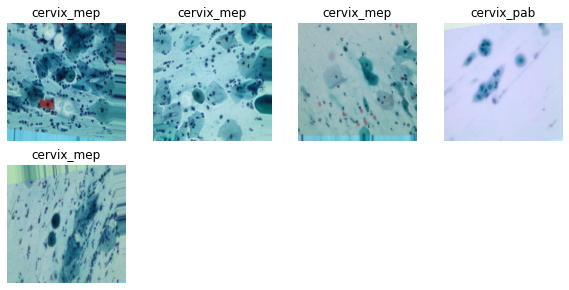

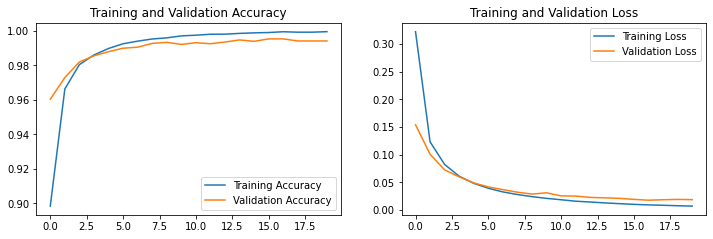

157/157 [==============================] - 24s 156ms/step - loss: 0.0188 - accuracy: 0.9942
Accuracy on the Test Set = 99.42 %
Model Saved!
True :  [0 0 0 ... 4 4 4]
Predicted :  [0 0 0 ... 4 4 4]


<Figure size 432x288 with 0 Axes>

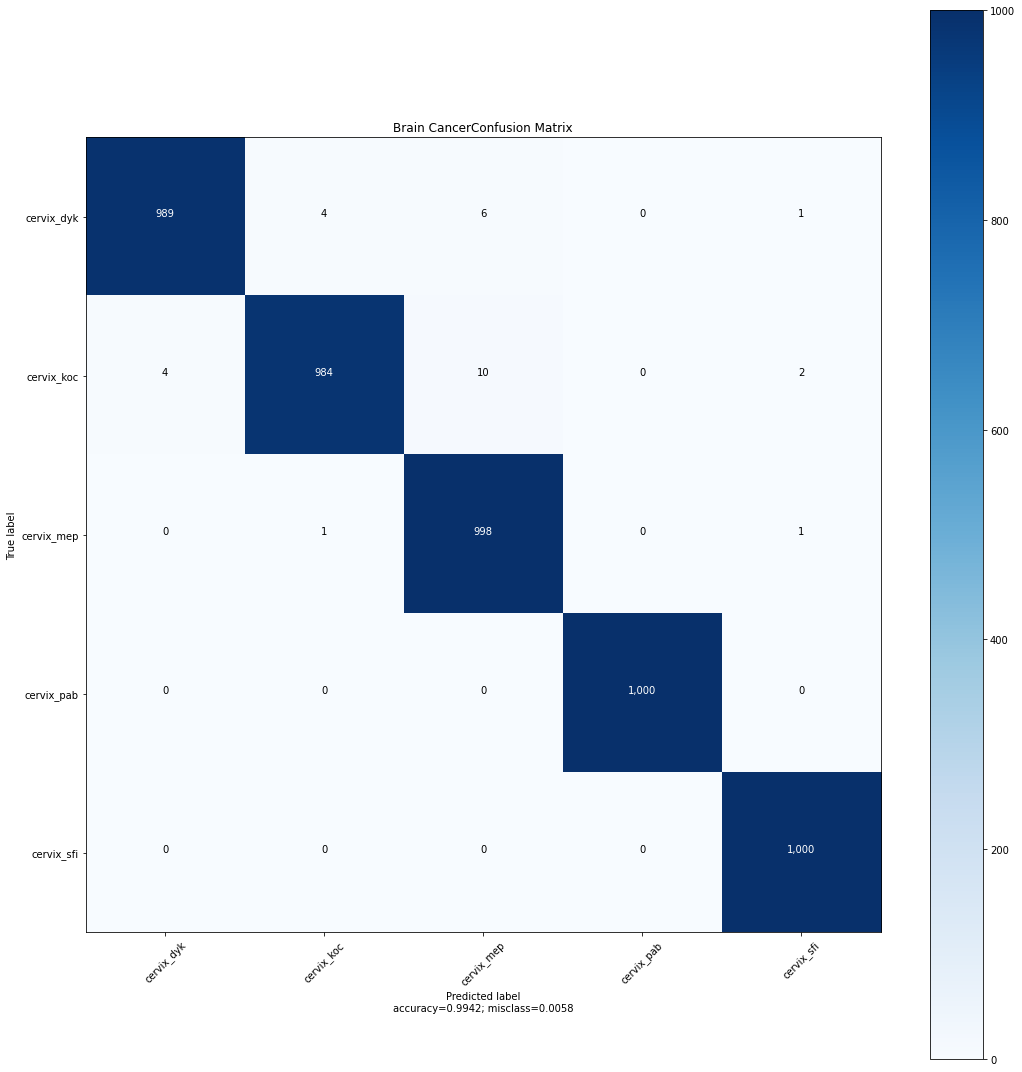

<Figure size 432x288 with 0 Axes>

In [57]:
cpath = os.path.join(mpath, 'Cervical Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 20000 images belonging to 5 classes.

For Val :  Found 5000 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_5 (Rescaling)         (None, 224, 224, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_5[0][0]              

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
625/625 [==============================] - 129s 206ms/step - loss: 0.0576 - accuracy: 0.9803 - val_loss: 0.0582 - val_accuracy: 0.9776

Epoch 00002: val_loss improved from 0.08442 to 0.05825, saving model to Brain CancerMobileNet.h5
Epoch 3/20
625/625 [==============================] - 129s 206ms/step - loss: 0.0414 - accuracy: 0.9868 - val_loss: 0.0418 - val_accuracy: 0.9880

Epoch 00003: val_loss improved from 0.05825 to 0.04177, saving model to Brain CancerMobileNet.h5
Epoch 4/20
625/625 [==============================] - 129s 207ms/step - loss: 0.0327 - accuracy: 0.9894 - val_loss: 0.0350 - val_accuracy: 0.9880

Epoch 00004: val_loss improved from 0.04177 to 0.03499, saving model to Brain CancerMobileNet.h5
Epoch 5/20
625/625 [==============================] - 129s 206ms/step - loss: 0.0268 - accuracy: 0.9921 - val_loss: 0.0390 - val_accuracy: 0.9858

Epoch 00005: val_loss did not improve from 0.03499
Epoch 6/20
625/625 [==============================] - 129s 206ms/step 

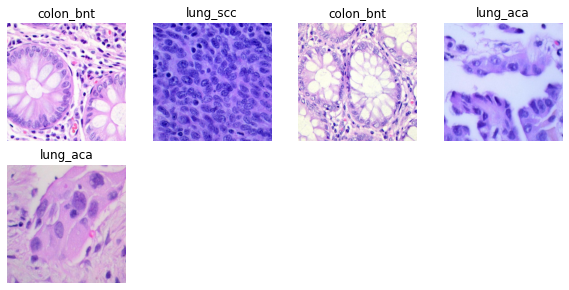

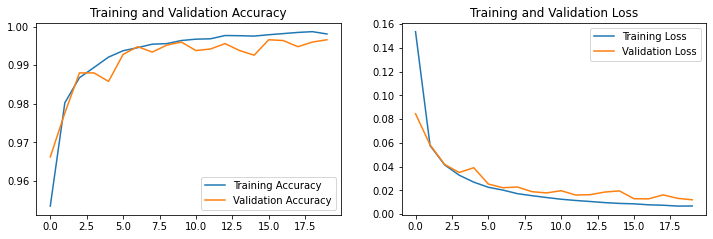

157/157 [==============================] - 25s 162ms/step - loss: 0.0120 - accuracy: 0.9966
Accuracy on the Test Set = 99.66 %
Model Saved!
True :  [0 0 0 ... 4 4 4]
Predicted :  [0 1 0 ... 4 4 4]


<Figure size 432x288 with 0 Axes>

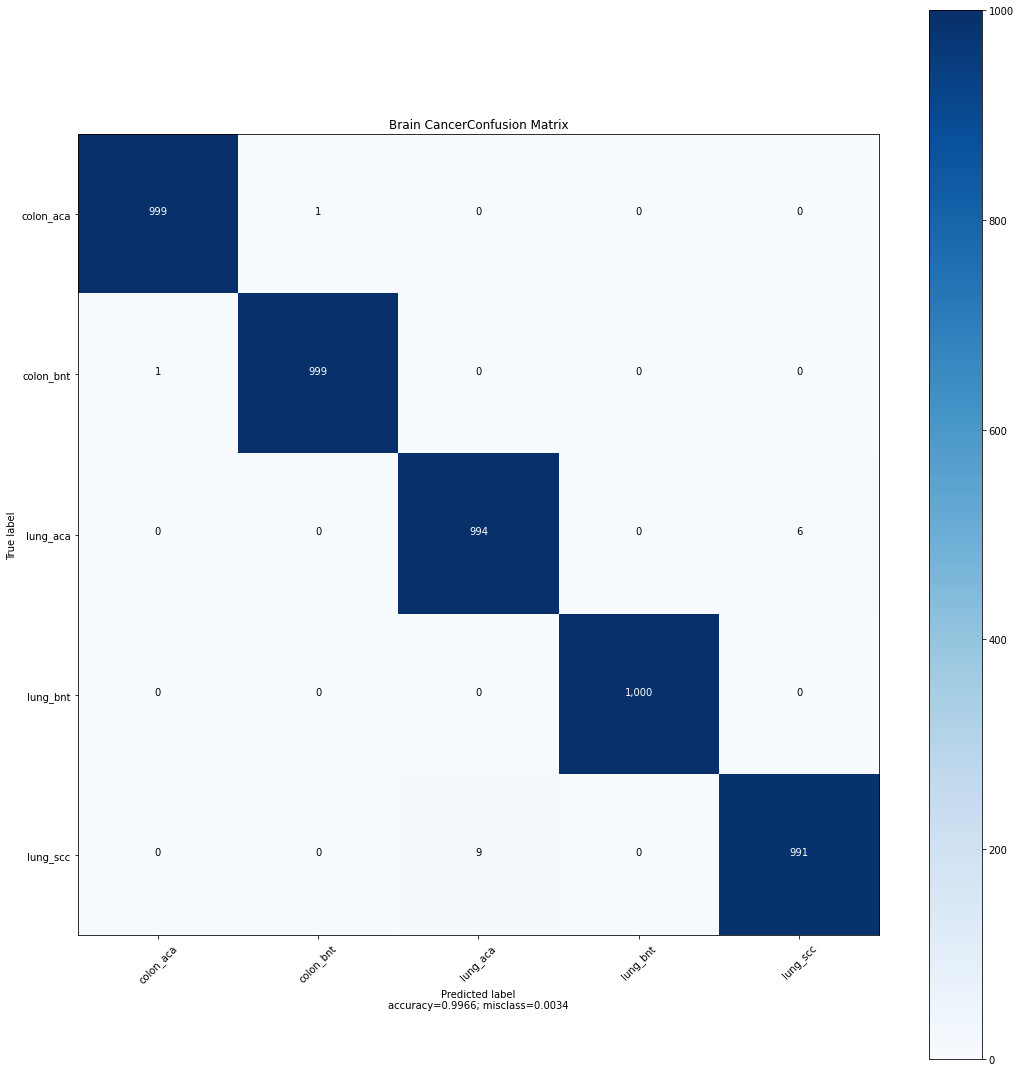

<Figure size 432x288 with 0 Axes>

In [58]:
cpath = os.path.join(mpath, 'Lung and Colon Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10002 files belonging to 2 classes.

For Training :  Found 8002 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['oral_normal', 'oral_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_6 (Rescaling)         (None, 224, 224, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_6[0][0]                
_________________________________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
251/251 [==============================] - 51s 202ms/step - loss: 0.3370 - accuracy: 0.8562 - val_loss: 0.3635 - val_accuracy: 0.8405

Epoch 00002: val_loss improved from 0.39008 to 0.36347, saving model to Brain CancerMobileNet.h5
Epoch 3/20
251/251 [==============================] - 51s 205ms/step - loss: 0.3044 - accuracy: 0.8728 - val_loss: 0.3390 - val_accuracy: 0.8555

Epoch 00003: val_loss improved from 0.36347 to 0.33896, saving model to Brain CancerMobileNet.h5
Epoch 4/20
251/251 [==============================] - 51s 201ms/step - loss: 0.2831 - accuracy: 0.8840 - val_loss: 0.3250 - val_accuracy: 0.8625

Epoch 00004: val_loss improved from 0.33896 to 0.32497, saving model to Brain CancerMobileNet.h5
Epoch 5/20
251/251 [==============================] - 51s 203ms/step - loss: 0.2684 - accuracy: 0.8939 - val_loss: 0.3154 - val_accuracy: 0.8620

Epoch 00005: val_loss improved from 0.32497 to 0.31543, saving model to Brain CancerMobileNet.h5
Epoch 6/20
251/251 [========

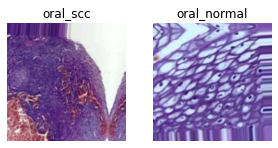

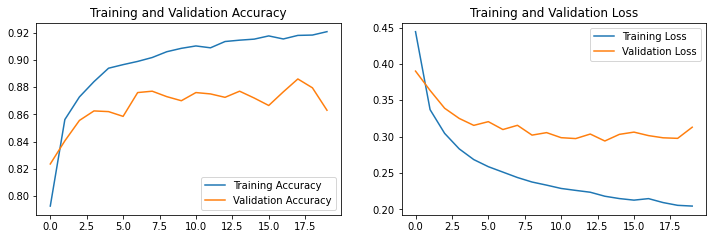

63/63 [==============================] - 10s 165ms/step - loss: 0.3129 - accuracy: 0.8630
Accuracy on the Test Set = 86.30 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

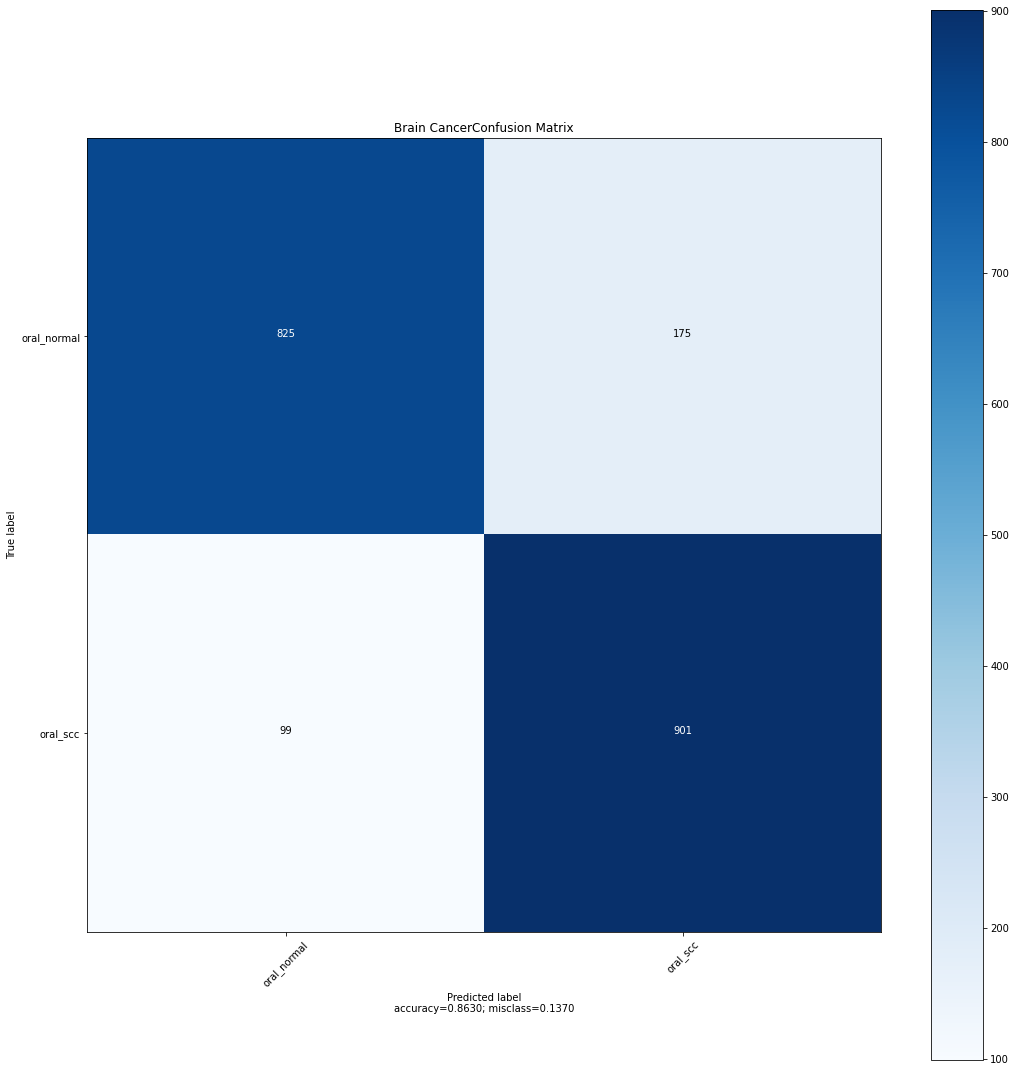

<Figure size 432x288 with 0 Axes>

In [59]:
cpath = os.path.join(mpath, 'Oral Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 20000 files belonging to 4 classes.

For Training :  Found 16000 images belonging to 4 classes.

For Val :  Found 4000 images belonging to 4 classes.

No of Classes :  4
Classes :  ['all_benign', 'all_early', 'all_pre', 'all_pro']
Image Shape :  (32, 256, 256, 3)
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_7 (Rescaling)         (None, 224, 224, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_7[0][0]                
__________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
500/500 [==============================] - 92s 184ms/step - loss: 0.0499 - accuracy: 0.9901 - val_loss: 0.0361 - val_accuracy: 0.9933

Epoch 00002: val_loss improved from 0.06321 to 0.03605, saving model to Brain CancerMobileNet.h5
Epoch 3/20
500/500 [==============================] - 92s 184ms/step - loss: 0.0326 - accuracy: 0.9927 - val_loss: 0.0270 - val_accuracy: 0.9945

Epoch 00003: val_loss improved from 0.03605 to 0.02699, saving model to Brain CancerMobileNet.h5
Epoch 4/20
500/500 [==============================] - 93s 186ms/step - loss: 0.0241 - accuracy: 0.9952 - val_loss: 0.0217 - val_accuracy: 0.9950

Epoch 00004: val_loss improved from 0.02699 to 0.02165, saving model to Brain CancerMobileNet.h5
Epoch 5/20
500/500 [==============================] - 94s 188ms/step - loss: 0.0187 - accuracy: 0.9967 - val_loss: 0.0169 - val_accuracy: 0.9950

Epoch 00005: val_loss improved from 0.02165 to 0.01687, saving model to Brain CancerMobileNet.h5
Epoch 6/20
500/500 [========

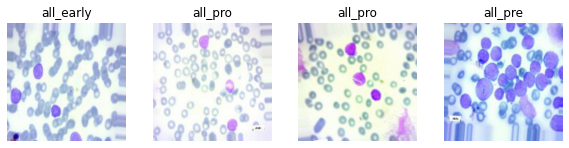

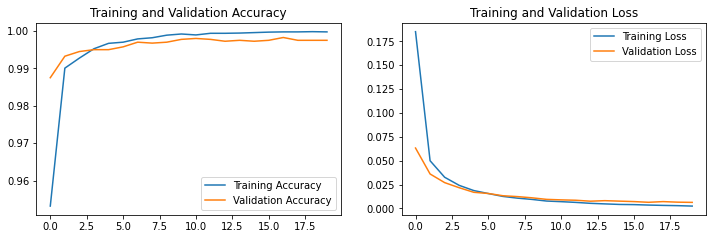

125/125 [==============================] - 18s 145ms/step - loss: 0.0063 - accuracy: 0.9975
Accuracy on the Test Set = 99.75 %
Model Saved!
True :  [0 0 0 ... 3 3 3]
Predicted :  [0 0 0 ... 3 3 3]


<Figure size 432x288 with 0 Axes>

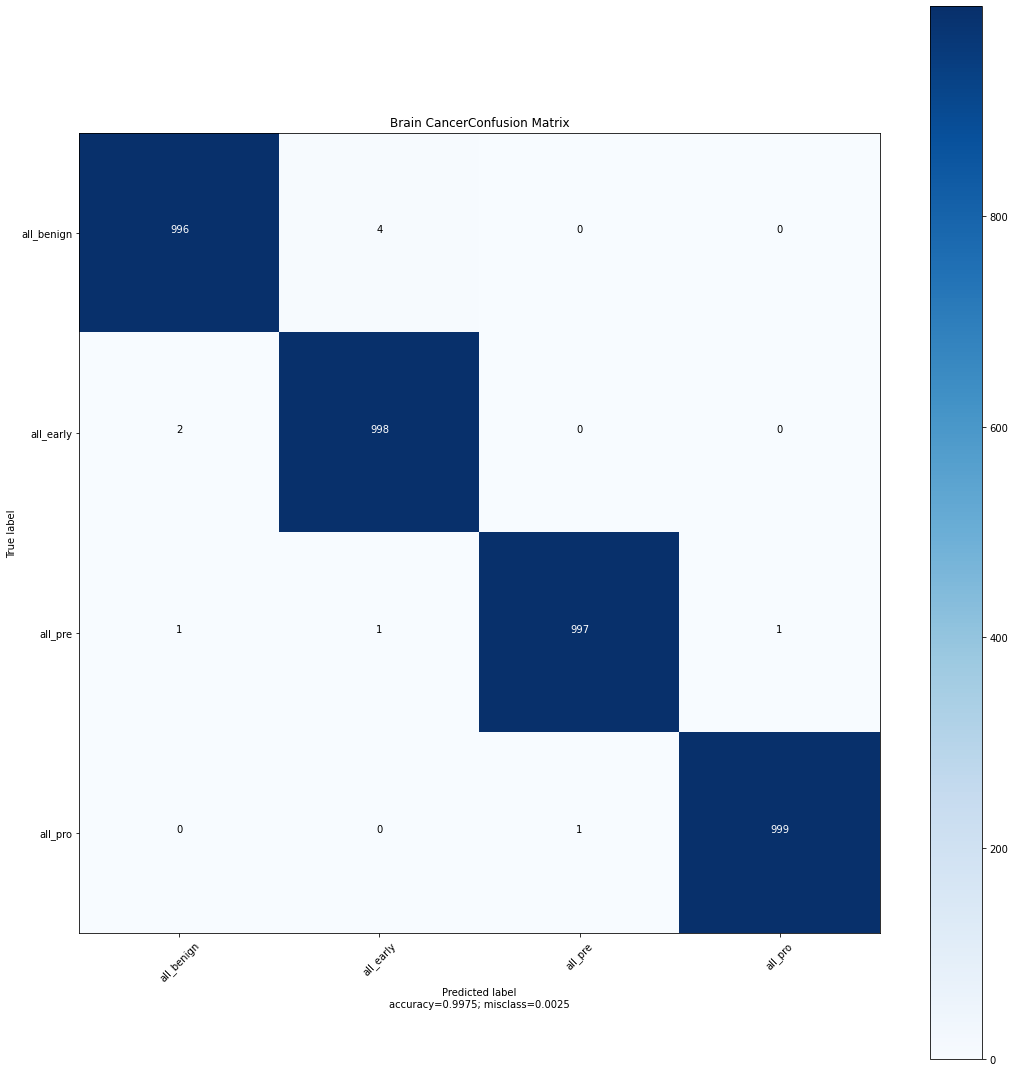

<Figure size 432x288 with 0 Axes>

In [60]:
cpath = os.path.join(mpath, 'ALL')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 8000 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['kidney_normal', 'kidney_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_9 (Rescaling)         (None, 224, 224, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_9[0][0]                
___________________________

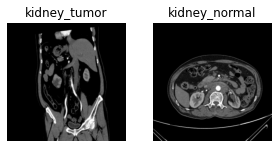

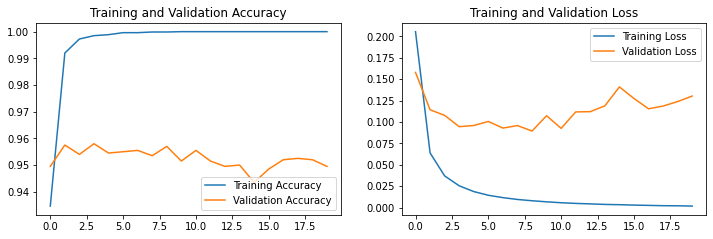

63/63 [==============================] - 9s 147ms/step - loss: 0.1303 - accuracy: 0.9495
Accuracy on the Test Set = 94.95 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

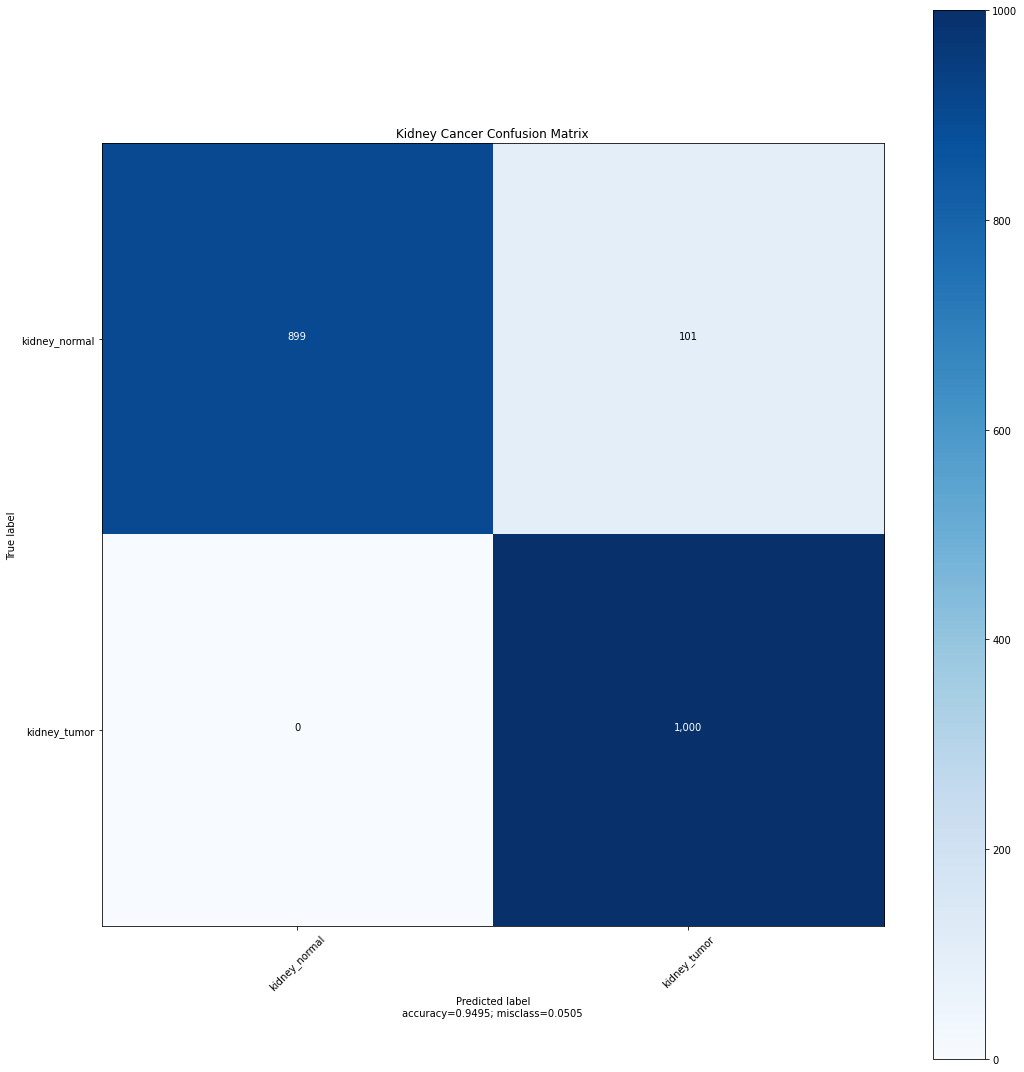

<Figure size 432x288 with 0 Axes>

In [62]:
className = 'Kidney Cancer '
cpath = os.path.join(mpath, 'Kidney Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 8000 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_10 (Rescaling)        (None, 224, 224, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_10[0][0]               
_______________________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
250/250 [==============================] - 76s 306ms/step - loss: 0.0348 - accuracy: 0.9902 - val_loss: 0.0594 - val_accuracy: 0.9795

Epoch 00002: val_loss improved from 0.07687 to 0.05944, saving model to Breast Cancer MobileNet.h5
Epoch 3/20
250/250 [==============================] - 76s 306ms/step - loss: 0.0264 - accuracy: 0.9924 - val_loss: 0.0579 - val_accuracy: 0.9800

Epoch 00003: val_loss improved from 0.05944 to 0.05795, saving model to Breast Cancer MobileNet.h5
Epoch 4/20
250/250 [==============================] - 77s 306ms/step - loss: 0.0212 - accuracy: 0.9942 - val_loss: 0.0711 - val_accuracy: 0.9710

Epoch 00004: val_loss did not improve from 0.05795
Epoch 5/20
250/250 [==============================] - 76s 306ms/step - loss: 0.0184 - accuracy: 0.9959 - val_loss: 0.0611 - val_accuracy: 0.9765

Epoch 00005: val_loss did not improve from 0.05795
Epoch 6/20
250/250 [==============================] - 77s 307ms/step - loss: 0.0159 - accuracy: 0.9958 - val_loss: 0

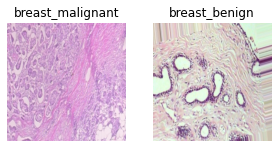

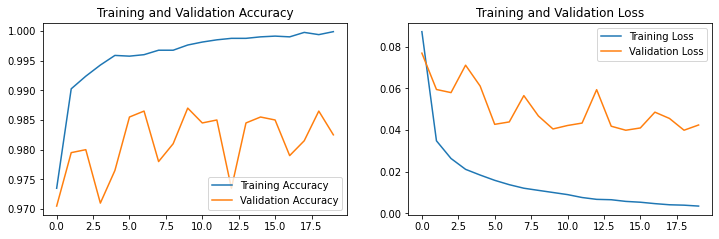

63/63 [==============================] - 15s 239ms/step - loss: 0.0424 - accuracy: 0.9825
Accuracy on the Test Set = 98.25 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

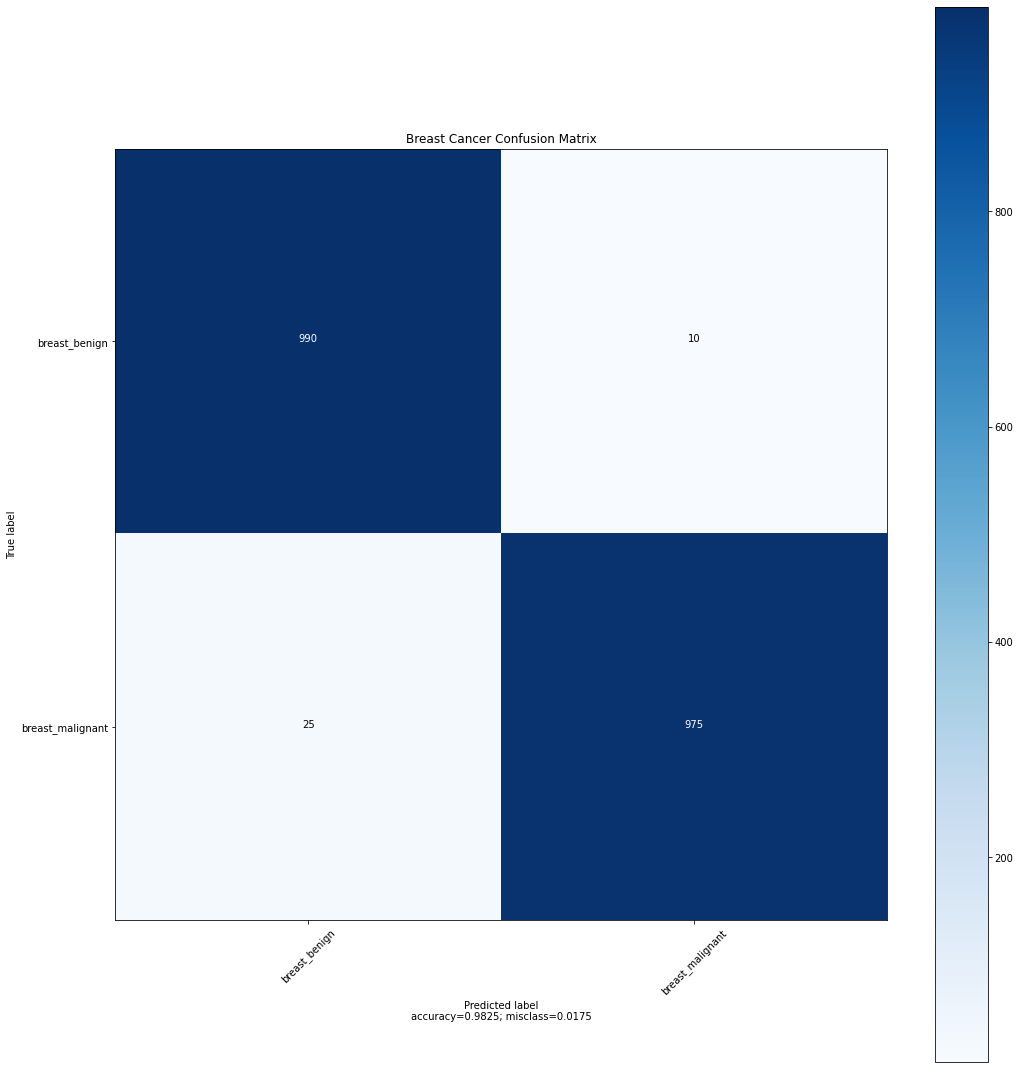

<Figure size 432x288 with 0 Axes>

In [63]:
className = 'Breast Cancer '
cpath = os.path.join(mpath, 'Breast Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 12000 images belonging to 3 classes.

For Val :  Found 3000 images belonging to 3 classes.

No of Classes :  3
Classes :  ['lymph_cll', 'lymph_fl', 'lymph_mcl']
Image Shape :  (32, 256, 256, 3)
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_11 (Rescaling)        (None, 224, 224, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_11[0][0]               
____________________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
375/375 [==============================] - 86s 229ms/step - loss: 0.5631 - accuracy: 0.7744 - val_loss: 0.5428 - val_accuracy: 0.7790

Epoch 00002: val_loss improved from 0.61403 to 0.54285, saving model to Lymphoma MobileNet.h5
Epoch 3/20
375/375 [==============================] - 85s 227ms/step - loss: 0.4972 - accuracy: 0.8048 - val_loss: 0.4964 - val_accuracy: 0.8043

Epoch 00003: val_loss improved from 0.54285 to 0.49643, saving model to Lymphoma MobileNet.h5
Epoch 4/20
375/375 [==============================] - 85s 227ms/step - loss: 0.4616 - accuracy: 0.8181 - val_loss: 0.4659 - val_accuracy: 0.8127

Epoch 00004: val_loss improved from 0.49643 to 0.46591, saving model to Lymphoma MobileNet.h5
Epoch 5/20
375/375 [==============================] - 85s 228ms/step - loss: 0.4338 - accuracy: 0.8339 - val_loss: 0.4462 - val_accuracy: 0.8283

Epoch 00005: val_loss improved from 0.46591 to 0.44621, saving model to Lymphoma MobileNet.h5
Epoch 6/20
375/375 [====================

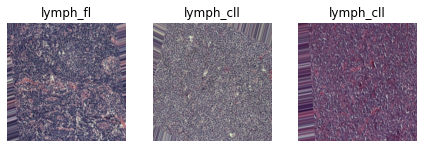

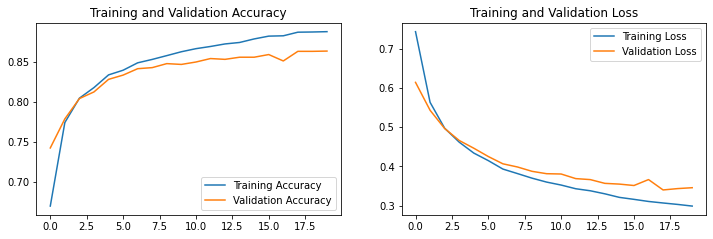

94/94 [==============================] - 17s 185ms/step - loss: 0.3455 - accuracy: 0.8637
Accuracy on the Test Set = 86.37 %
Model Saved!
True :  [0 0 0 ... 2 2 2]
Predicted :  [0 0 0 ... 2 2 2]


<Figure size 432x288 with 0 Axes>

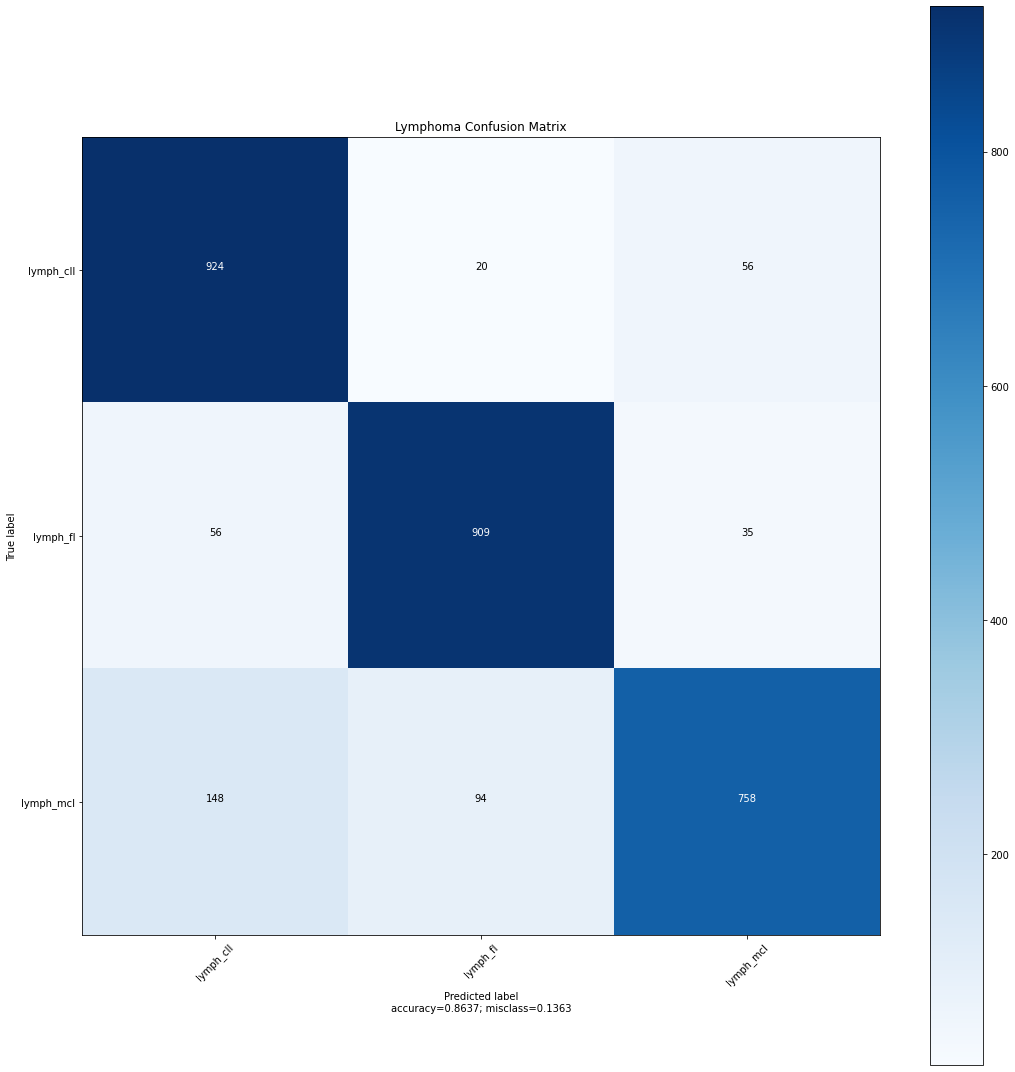

<Figure size 432x288 with 0 Axes>

In [64]:
className = 'Lymphoma '
cpath = os.path.join(mpath, 'Lymphoma')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 12000 images belonging to 3 classes.

For Val :  Found 3000 images belonging to 3 classes.

No of Classes :  3
Classes :  ['brain_glioma', 'brain_menin', 'brain_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_12 (Rescaling)        (None, 224, 224, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_12[0][0]               
____________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
375/375 [==============================] - 68s 180ms/step - loss: 0.1773 - accuracy: 0.9412 - val_loss: 0.1626 - val_accuracy: 0.9403

Epoch 00002: val_loss improved from 0.20705 to 0.16258, saving model to Brain Cancer MobileNet.h5
Epoch 3/20
375/375 [==============================] - 66s 177ms/step - loss: 0.1433 - accuracy: 0.9543 - val_loss: 0.1422 - val_accuracy: 0.9497

Epoch 00003: val_loss improved from 0.16258 to 0.14220, saving model to Brain Cancer MobileNet.h5
Epoch 4/20
375/375 [==============================] - 67s 178ms/step - loss: 0.1242 - accuracy: 0.9602 - val_loss: 0.1298 - val_accuracy: 0.9517

Epoch 00004: val_loss improved from 0.14220 to 0.12979, saving model to Brain Cancer MobileNet.h5
Epoch 5/20
375/375 [==============================] - 67s 178ms/step - loss: 0.1094 - accuracy: 0.9662 - val_loss: 0.1096 - val_accuracy: 0.9600

Epoch 00005: val_loss improved from 0.12979 to 0.10956, saving model to Brain Cancer MobileNet.h5
Epoch 6/20
375/375 [====

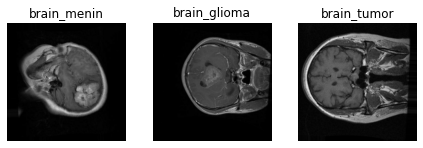

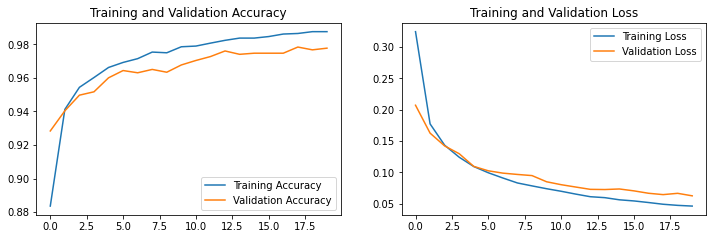

94/94 [==============================] - 14s 143ms/step - loss: 0.0627 - accuracy: 0.9777
Accuracy on the Test Set = 97.77 %
Model Saved!
True :  [0 0 0 ... 2 2 2]
Predicted :  [0 0 0 ... 2 2 2]


<Figure size 432x288 with 0 Axes>

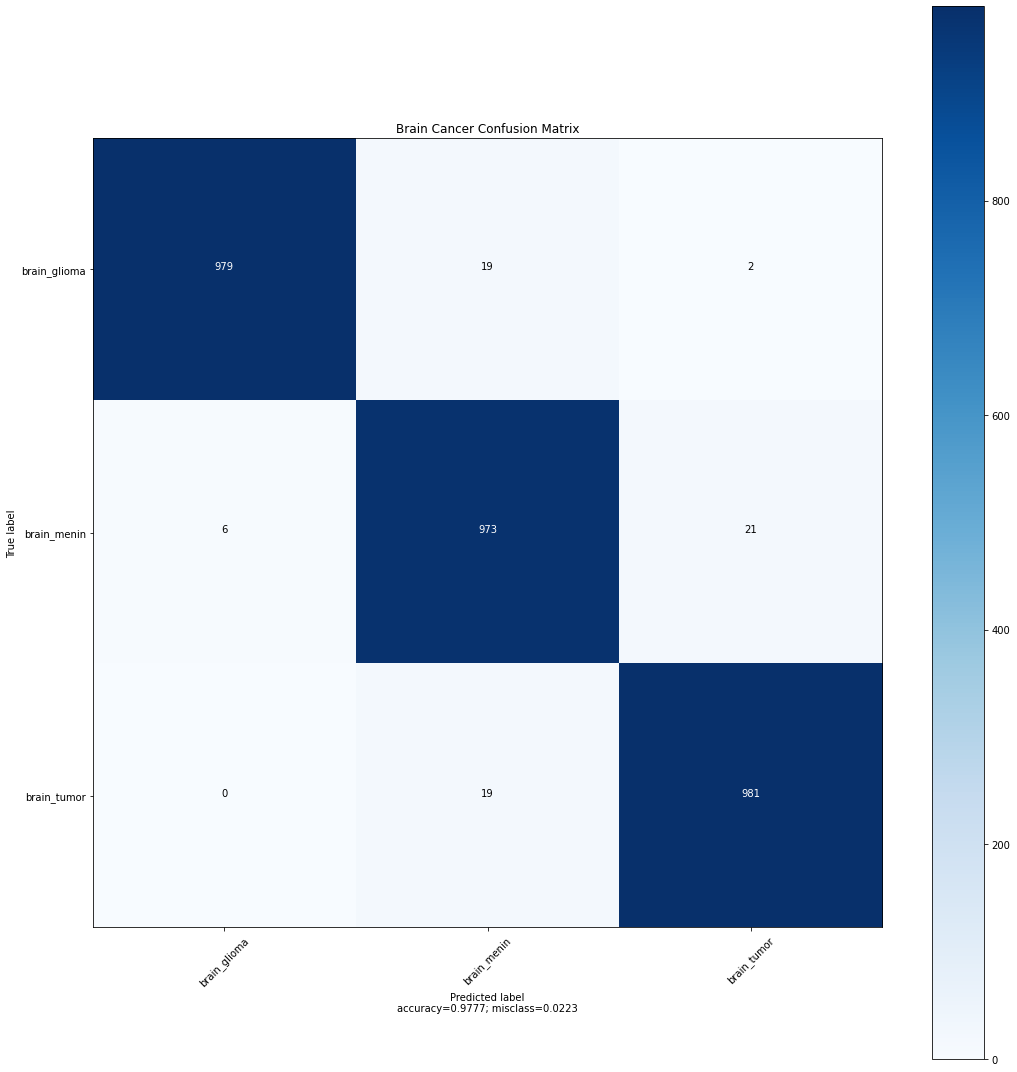

<Figure size 432x288 with 0 Axes>

In [65]:
className = 'Brain Cancer '
cpath = os.path.join(mpath, 'Brain Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)